In [1]:
import numpy as np
import matplotlib.pyplot as plt
from plotbin.plot_velfield import plot_velfield
from My_Jampy import JAM                          #My class for jampy


from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u

In [2]:
y, x, vrms, erms              = np.loadtxt("Input/pPXF_rot_data.txt", unpack=True)          #vrms data
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)              #MGE decomposition
surf_dm, sigma_dm , qobs_dm   = np.loadtxt("Input/eNFW.txt", unpack=True)                   #DM component
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True)         #PSF

In [3]:
z_l     = 0.299                                                         #Redshift
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, -0.15)                                  #anisotropy [ad]
inc     = 65                                                            #inclination [deg]
kappa_s = 0.075                                                         #kappa_s of DM profile
ml      = 7.00                                                          #mass to light ratio
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                        (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)       #Deprojected axial ratio for inclination
qDM     = np.sqrt( qobs_dm[0]**2 - np.cos(inc_rad)**2)/np.sin(inc_rad)  #Deprojected DM axial ratio

pixsize = 0.2    #MUSE pixel size

In [4]:
#Now we start our Jampy class
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms, erms=erms,
                   normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)
#Add DM component
Jam_model.DM_component(surf_dm=kappa_s * surf_dm, sigma_dm=sigma_dm, qobs_dm=qobs_dm)

In [5]:
boundary = {"ml": [0.5, 15], "qinc": [0.051, 0.55], "beta": [-3, 3],
                "log_mbh": [7, 11], "kappa_s": [0, 1], "qDM":[0.1, 1]}

def prior_transform(theta):
    ml, qinc, beta, log_mbh, kappa_s, qDM = theta
    parsDic = {"ml":ml, "qinc":qinc, "beta":beta, "log_mbh":log_mbh, "kappa_s":kappa_s, "qDM":qDM }
    for key in parsDic:
        parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
    
    return np.array(list(parsDic.values()))

def log_likelihood(theta):
    ml, qinc, beta, log_mbh, kappa_s, qDM = theta    
    # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
    qmin = np.min(qobs_lum)
    inc_model = np.degrees(np.arctan(np.sqrt((1 - qmin**2)/(qmin**2 -qinc**2))))
    
    surf_dm_model = (kappa_s) * surf_dm
    qdm_proj      = np.sqrt( (np.sin(np.radians(inc_model)) * qDM )**2  + np.cos( np.radians(inc_model))**2     )     #Projected DM axial ratio
    qDM_model     = np.ones_like(qobs_dm)*qdm_proj

    beta_model  = np.ones_like(surf_lum)*beta
    ml_model    = ml
    mbh_model   = 10**log_mbh
    
    Jam_model.upt(surf_dm=surf_dm_model, qobs_dm=qDM_model, inc=inc_model,
                        ml=ml_model, beta=beta_model, mbh=mbh_model)
    
    rmsModel, ml, chi2, chi2T = Jam_model.run(quiet=False, plot=True)
    
    
    return -0.5 * chi2T


jam_axi_rms elapsed time sec: 0.80
inc=65.0 beta_z=-0.15 M/L=1 BH=1.00e+09 chi2/DOF=42.4
Total mass MGE: 3.955e+13


-4937.966669547746

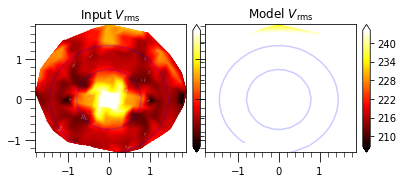

In [6]:
p0 = np.array([ml, qinc, beta[0], np.log10(mbh), kappa_s, qDM])
log_likelihood(p0)

In [7]:
from dynesty import NestedSampler, DynamicNestedSampler
from multiprocessing import Pool

In [25]:
nlive = 200      # number of (initial) live points
ndim  = p0.size  #number of dimensions


# Now run with the static sampler
sampler = NestedSampler(log_likelihood, prior_transform, ndim, pool=Pool(),queue_size=6,
                        nlive=nlive)

In [26]:
sampler.run_nested()
res = sampler.results

4243it [2:35:32,  2.20s/it, +200 | bound: 55 | nc: 1 | ncall: 23570 | eff(%): 18.850 | loglstar:   -inf < -161.731 <    inf | logz: -181.335 +/-  0.418 | dlogz:  0.001 >  0.209]


In [8]:
import pickle 

In [28]:
sampler_pickle = sampler

In [29]:
with open(f"jampy.pickle", "wb") as f:
                pickle.dump(sampler_pickle, f)

## Loading

In [9]:
with open(f'final_jam_run.pickle','rb') as f:
    sample_load = pickle.load(f)

In [19]:
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

res = sample_load.results
# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(res)
results_sim.summary()

Summary
nlive: 20
niter: 571
ncall: 2510
eff(%): 22.749
logz: -192.078 +/-  0.963


In [20]:
logZdynesty = results_sim.logz[-1]        # value of logZ
logZerrdynesty = results_sim.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [21]:
# output marginal likelihood
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty, logZerrdynesty))

Marginalised evidence (using static sampler) is -192.07780322006442 ± 0.9632900727681045


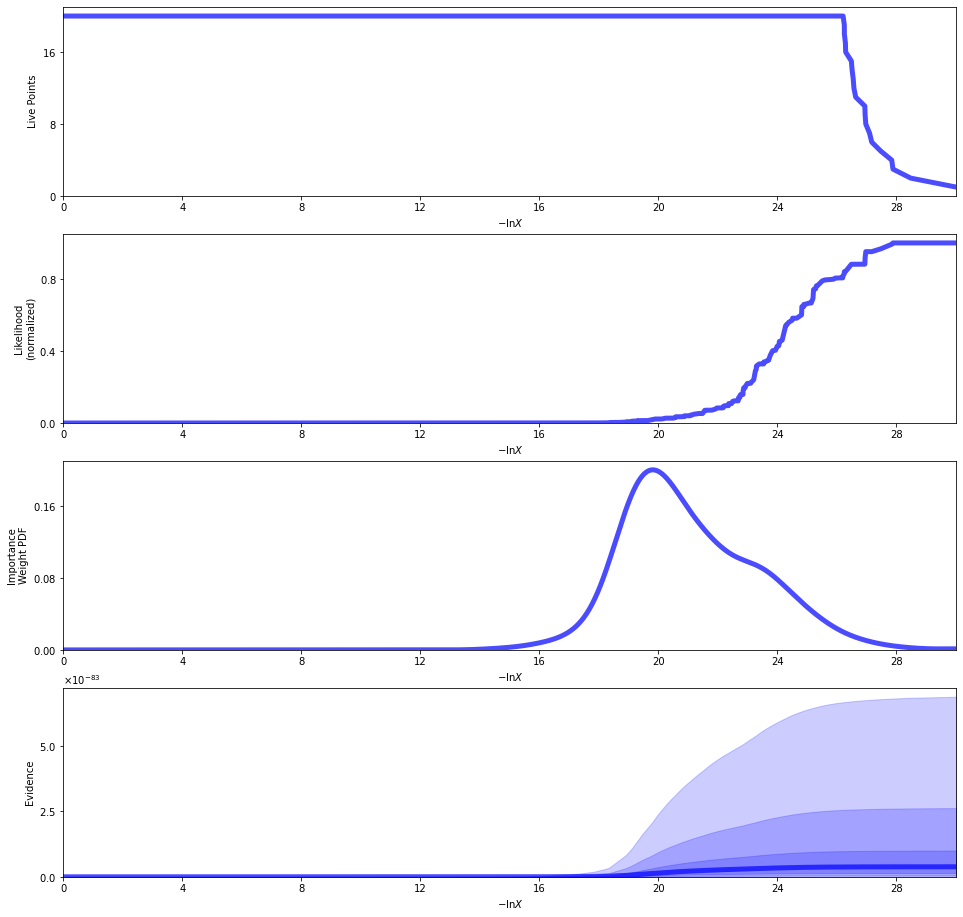

In [22]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results_sim)

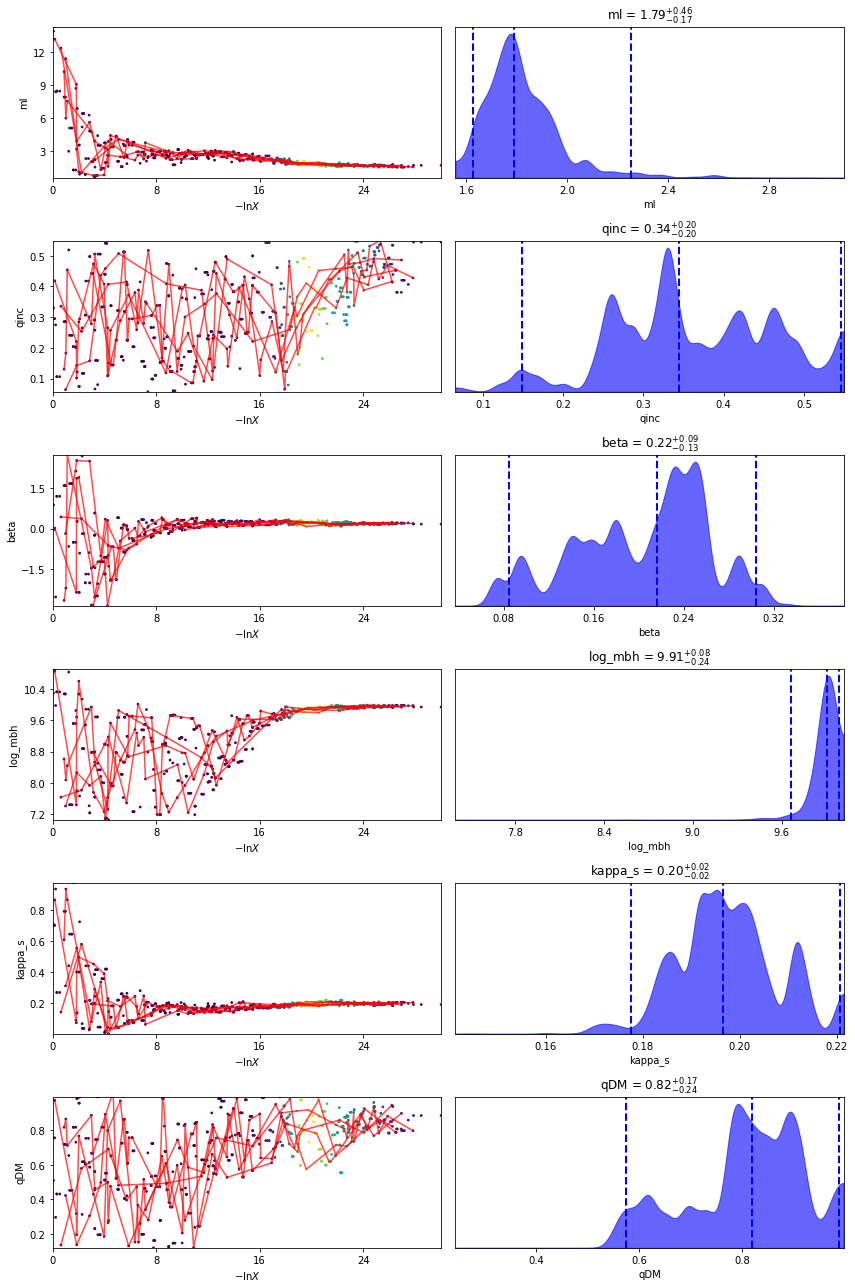

In [23]:
# Plot traces and 1-D marginalized posteriors.
labels = ["ml", "qinc", "beta", "log_mbh", "kappa_s", "qDM"]
tfig, taxes = dyplot.traceplot(results_sim,labels=labels,
                             truth_color='black', show_titles=True,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(10))

plt.tight_layout()

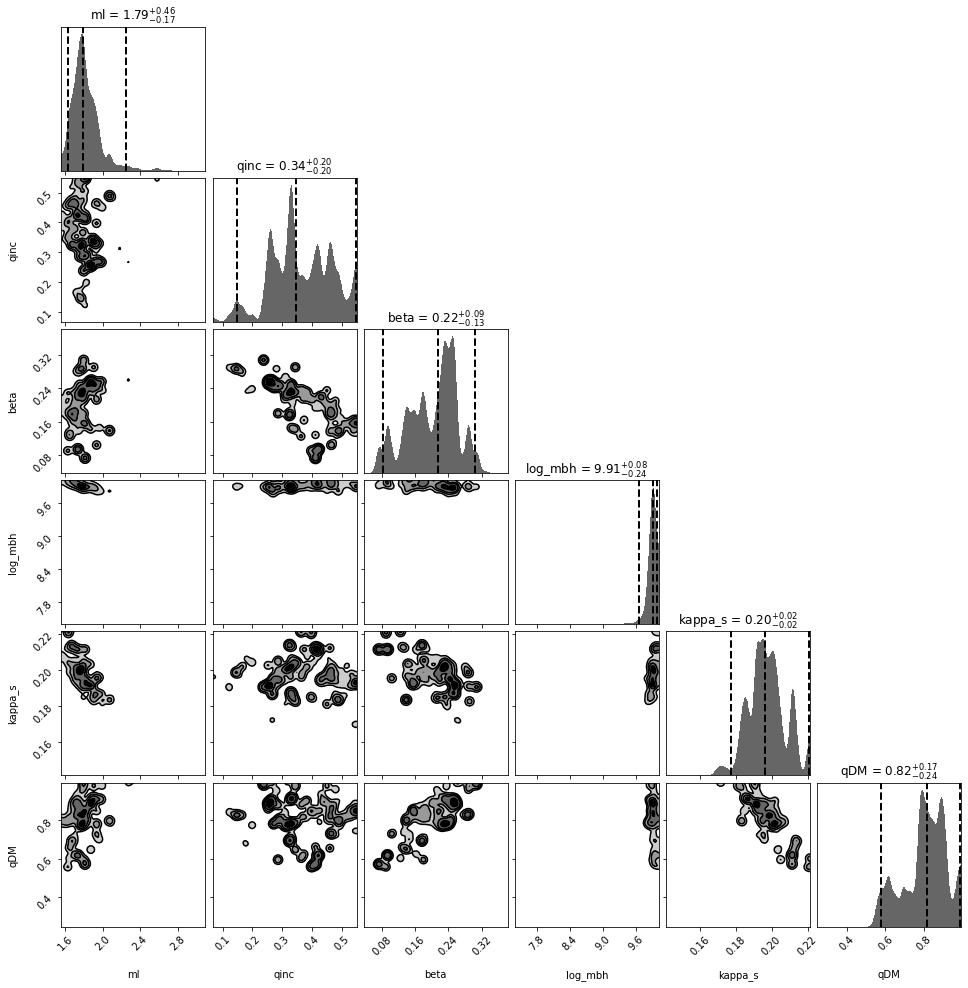

In [24]:
# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results_sim, show_titles=True,labels=labels,
                                )

In [25]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = results_sim.samples  # samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights)
             for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

In [26]:
mean

array([1.81953567, 0.36126886, 0.20231032, 9.89360041, 0.19732023,
       0.80402881])

In [27]:
print("Cov. Matrix")
with np.printoptions(formatter={'float': '{: 0.3e}'.format}, suppress=True):
    print((cov))

Cov. Matrix
[[ 2.429e-02 -1.411e-03  1.282e-03 -1.288e-02 -1.186e-03  3.646e-03]
 [-1.411e-03  1.000e-02 -4.109e-03  1.488e-03  1.854e-05 -1.322e-03]
 [ 1.282e-03 -4.109e-03  3.514e-03 -1.049e-03 -2.952e-04  4.871e-03]
 [-1.288e-02  1.488e-03 -1.049e-03  8.954e-03  5.399e-04 -1.367e-03]
 [-1.186e-03  1.854e-05 -2.952e-04  5.399e-04  1.046e-04 -8.429e-04]
 [ 3.646e-03 -1.322e-03  4.871e-03 -1.367e-03 -8.429e-04  1.222e-02]]


jam_axi_rms elapsed time sec: 0.57
inc=63.6 beta_z=0.20 M/L=1 BH=7.83e+09 chi2/DOF=1.48
Total mass MGE: 1.022e+14


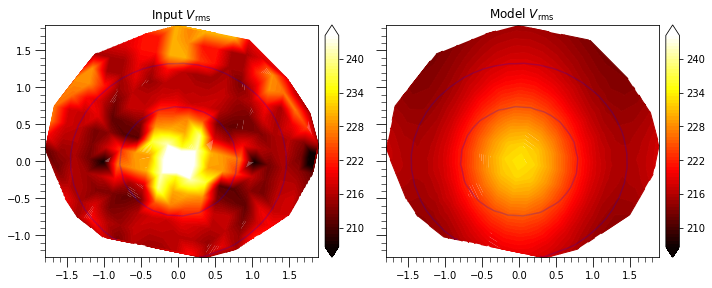

In [28]:
plt.figure(figsize=(10,8))
log_likelihood(mean)

plt.tight_layout()

jam_axi_rms elapsed time sec: 0.60
inc=63.6 beta_z=0.20 M/L=1 BH=7.83e+09 chi2/DOF=1.48
Total mass MGE: 1.022e+14


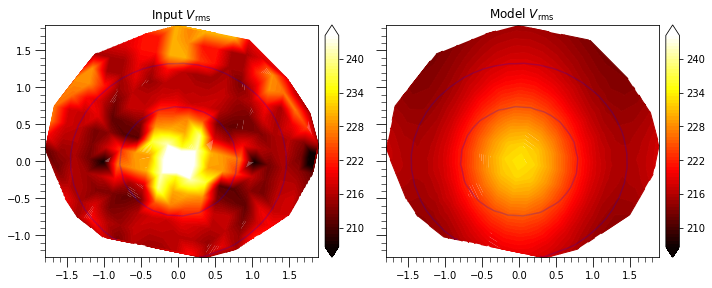

In [29]:
plt.figure(figsize=(10,8))

ml, qinc, beta, log_mbh, kappa_s, qDM = mean    
# Sample inclination using min(q), with Equation (14) of Cappellari (2008)
qmin = np.min(qobs_lum)
inc_model = np.degrees(np.arctan(np.sqrt((1 - qmin**2)/(qmin**2 -qinc**2))))

surf_dm_model = (kappa_s) * surf_dm
qdm_proj      = np.sqrt( (np.sin(np.radians(inc_model)) * qDM )**2  + np.cos( np.radians(inc_model))**2     )     #Projected DM axial ratio
qDM_model     = np.ones_like(qobs_dm)*qdm_proj

beta_model  = np.ones_like(surf_lum)*beta
ml_model    = ml
mbh_model   = 10**log_mbh

Jam_model.upt(surf_dm=surf_dm_model, qobs_dm=qDM_model, inc=inc_model,
                    ml=ml_model, beta=beta_model, mbh=mbh_model)

rmsModel, ml, chi2, chi2T = Jam_model.run(quiet=False, plot=True)
plt.tight_layout()

Text(0.5, 1.0, 'Residual Map')

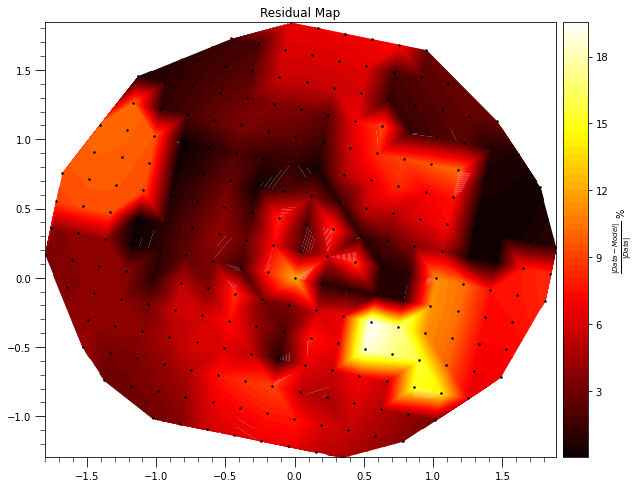

In [30]:
plt.figure(figsize=(10,8))

plot_velfield(x=x*pixsize, y=y*pixsize, vel=100*abs(vrms - rmsModel)/abs(vrms), 
              colorbar=True, cmap="hot", label="$\\frac{|Data-Model|}{|Data|}$ %")
plt.title("Residual Map")


Text(0.5, 1.0, 'Error Map')

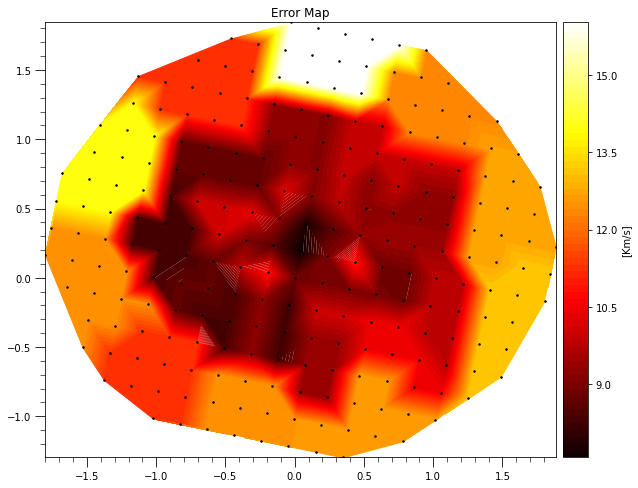

In [31]:
plt.figure(figsize=(10,8))

plot_velfield(x=x*pixsize, y=y*pixsize, vel=erms, colorbar=True, cmap="hot", label="[Km/s]")
plt.title("Error Map")

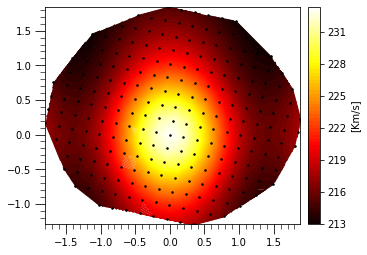

In [32]:
plot_velfield(x=x*pixsize, y=y*pixsize, vel=rmsModel, colorbar=True, cmap="hot", label="[Km/s]")

## Loading Results

In [73]:
with open(f'jampy.pickle','rb') as f:
    sample_load = pickle.load(f)

In [75]:
result2 = sample_load.results

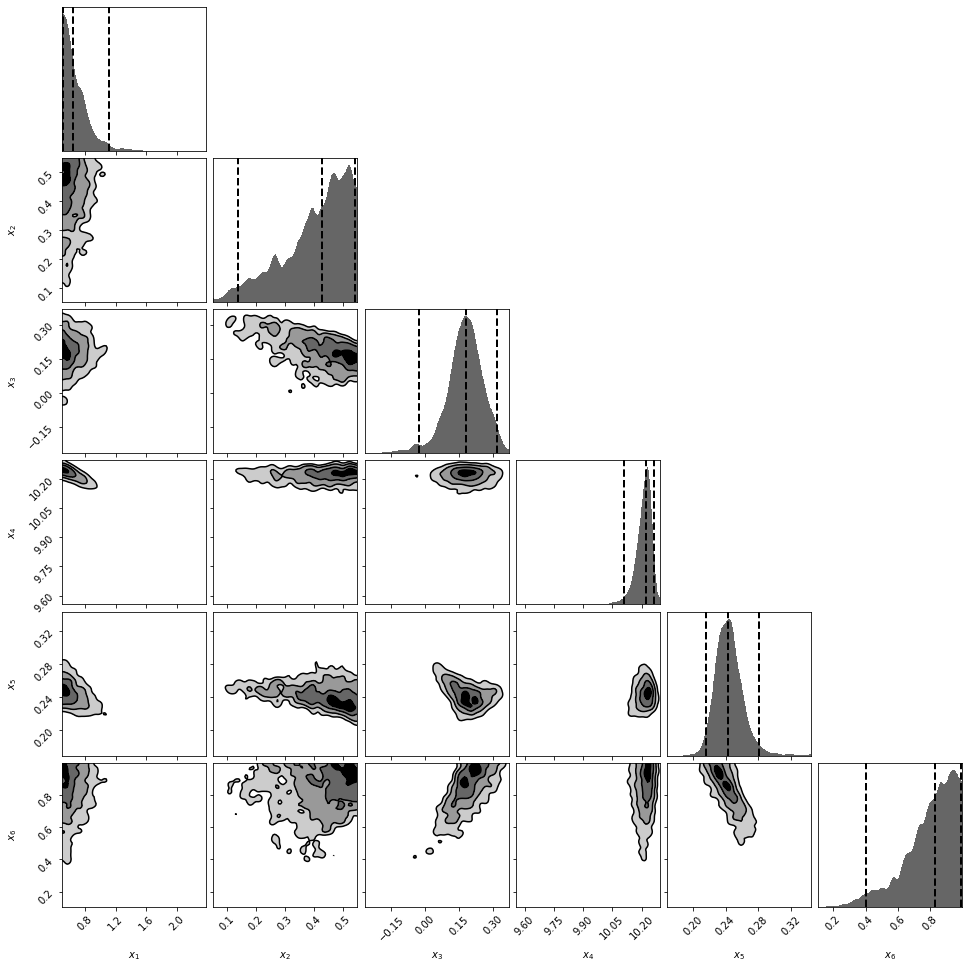

In [77]:
cfig, caxes =  dyplot.cornerplot(result2)

In [90]:
sample_load

23570